In [26]:
import tensorflow as tf
from tensorflow import keras
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [156]:
def adjust_gamma(image, gamma=1.0):
	# build a lookup table mapping the pixel values [0, 255] to
	# their adjusted gamma values
	invGamma = 1.0 / gamma
	table = np.array([((i / 255.0) ** invGamma) * 255
		for i in np.arange(0, 256)]).astype("uint8")
	# apply gamma correction using the lookup table

	return cv2.LUT(image, table)

* [How connect spectrum](www.fourmilab.ch/documents/specrend/)
* [Python library](https://python-colormath.readthedocs.io/en/latest/color_objects.html#spectralcolor)


In [175]:
# Spectrum to CIE
# from 380 nm to 780 nm by 5 nm steps
class SpectrumColor:
    MIN_NM = 380
    MAX_NM = 780
    STEP_NM = 5
    SPECTRUM_TO_CIE  = np.array([
                        [0.0014,0.0000,0.0065], [0.0022,0.0001,0.0105], [0.0042,0.0001,0.0201],
                        [0.0076,0.0002,0.0362], [0.0143,0.0004,0.0679], [0.0232,0.0006,0.1102],
                        [0.0435,0.0012,0.2074], [0.0776,0.0022,0.3713], [0.1344,0.0040,0.6456],
                        [0.2148,0.0073,1.0391], [0.2839,0.0116,1.3856], [0.3285,0.0168,1.6230],
                        [0.3483,0.0230,1.7471], [0.3481,0.0298,1.7826], [0.3362,0.0380,1.7721],
                        [0.3187,0.0480,1.7441], [0.2908,0.0600,1.6692], [0.2511,0.0739,1.5281],
                        [0.1954,0.0910,1.2876], [0.1421,0.1126,1.0419], [0.0956,0.1390,0.8130],
                        [0.0580,0.1693,0.6162], [0.0320,0.2080,0.4652], [0.0147,0.2586,0.3533],
                        [0.0049,0.3230,0.2720], [0.0024,0.4073,0.2123], [0.0093,0.5030,0.1582],
                        [0.0291,0.6082,0.1117], [0.0633,0.7100,0.0782], [0.1096,0.7932,0.0573],
                        [0.1655,0.8620,0.0422], [0.2257,0.9149,0.0298], [0.2904,0.9540,0.0203],
                        [0.3597,0.9803,0.0134], [0.4334,0.9950,0.0087], [0.5121,1.0000,0.0057],
                        [0.5945,0.9950,0.0039], [0.6784,0.9786,0.0027], [0.7621,0.9520,0.0021],
                        [0.8425,0.9154,0.0018], [0.9163,0.8700,0.0017], [0.9786,0.8163,0.0014],
                        [1.0263,0.7570,0.0011], [1.0567,0.6949,0.0010], [1.0622,0.6310,0.0008],
                        [1.0456,0.5668,0.0006], [1.0026,0.5030,0.0003], [0.9384,0.4412,0.0002],
                        [0.8544,0.3810,0.0002], [0.7514,0.3210,0.0001], [0.6424,0.2650,0.0000],
                        [0.5419,0.2170,0.0000], [0.4479,0.1750,0.0000], [0.3608,0.1382,0.0000],
                        [0.2835,0.1070,0.0000], [0.2187,0.0816,0.0000], [0.1649,0.0610,0.0000],
                        [0.1212,0.0446,0.0000], [0.0874,0.0320,0.0000], [0.0636,0.0232,0.0000],
                        [0.0468,0.0170,0.0000], [0.0329,0.0119,0.0000], [0.0227,0.0082,0.0000],
                        [0.0158,0.0057,0.0000], [0.0114,0.0041,0.0000], [0.0081,0.0029,0.0000],
                        [0.0058,0.0021,0.0000], [0.0041,0.0015,0.0000], [0.0029,0.0010,0.0000],
                        [0.0020,0.0007,0.0000], [0.0014,0.0005,0.0000], [0.0010,0.0004,0.0000],
                        [0.0007,0.0002,0.0000], [0.0005,0.0002,0.0000], [0.0003,0.0001,0.0000],
                        [0.0002,0.0001,0.0000], [0.0002,0.0001,0.0000], [0.0001,0.0000,0.0000],
                        [0.0001,0.0000,0.0000], [0.0001,0.0000,0.0000], [0.0000,0.0000,0.0000]
])
    @classmethod
    def get_coef(cls, from_nm, to_nm):
        assert cls.MIN_NM <= from_nm <= from_nm
        assert from_nm <= to_nm <= cls.MAX_NM
        assert from_nm % cls.STEP_NM == 0
        assert to_nm % cls.STEP_NM == 0
        to_nm = (to_nm - cls.MIN_NM ) // cls.STEP_NM
        from_nm = (from_nm - cls.MIN_NM) // cls.STEP_NM
        return np.mean(cls.SPECTRUM_TO_CIE[from_nm:to_nm+1], axis=0)

    @classmethod
    def create_filter(cls, min_wl=380, max_wl=780, step_wl=25):
        assert (max_wl - min_wl) % step_wl == 0
        assert step_wl >= 5, "The approximation function from spectrum to cie has sensitivity 5 nm"
        filter = np.array([SpectrumColor.get_coef(i, i+25) for i in range(min_wl, max_wl, step_wl)])
        return filter

In [176]:
def wavelength2rgb(in_image, min_wl=380,max_wl=780, step_wl=25):
    from skimage.color import xyz2rgb
    f = SpectrumColor.create_filter()
    out_image = np.zeros((*input_data.shape[:2], 3))
    for x in range(in_image.shape[0]):
        for y in range(in_image.shape[1]):
            out_image[x,y] = np.matmul(in_image[x, y], f) / np.sum(f)
    return xyz2rgb(out_image)

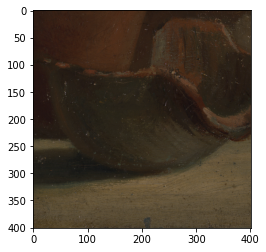

In [177]:
plt.imshow(wavelength2rgb(in_image))
plt.imsave('image.png', wavelength2rgb(in_image))

In [144]:
#Data
training_set_size = 25000
image_path = '../data/raw/still_life/sample_18.mat'
input_data = sio.loadmat(image_path)['data']
visible = input_data[:, :, 0:16] / 255.0
target = np.expand_dims(
    input_data[:, :,  26] / 255.0,
    axis=-1)

inputs = visible.reshape([visible.shape[0] * visible.shape[1],
                          1,
                          1,
                          visible.shape[2]])
outputs = target.reshape([target.shape[0] * target.shape[1],
                          1,
                          1,
                          target.shape[2]])
perm = np.random.permutation(inputs.shape[0])
ins  = inputs[perm[:training_set_size], :]
outs = outputs[perm[:training_set_size], :]

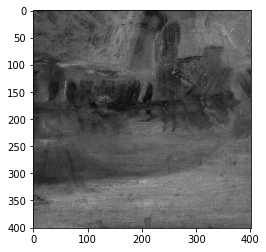

In [146]:
plt.imshow(target, cmap=plt.cm.gray)

In [150]:
input_shape = [1, 1, 16]
input_layer = keras.layers.Input(shape=input_shape)
num_layers = 2
filters = 15

layer = input_layer
for i in range(num_layers):
    layer = keras.layers.Conv2D(filters=25,
                                kernel_size=1,
                                activation='sigmoid',
                                padding='same')(layer)
output_layer = keras.layers.Dense(units=1, activation='sigmoid')(layer)
model = keras.Model(inputs=input_layer, outputs=output_layer)

In [151]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 16)]        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 25)          425       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 25)          650       
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1, 1)           26        
Total params: 1,101
Trainable params: 1,101
Non-trainable params: 0
_________________________________________________________________


In [152]:
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error']
              )

callbacks = [tf.keras.callbacks.EarlyStopping(patience=6,
                                              min_delta=10 ** -5)]
history = model.fit(ins,
                    outs,
                    epochs=10,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=callbacks
                    )

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 1s 30us/sample - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 0.0046 - val_mean_squared_error: 0.0046

In [153]:
print(model.predict(inputs).shape)
print(outputs.shape)
# calculate gain and print it out
gain = abs(outputs - model.predict(inputs)) / (outputs.shape[0] * outputs.shape[1])
print('Gain: {:1.4e}'.format(gain.flatten().max()))

(160801, 1, 1, 1)
(160801, 1, 1, 1)
Gain: 3.6143e-06


In [184]:
extrapolation = model.predict(inputs)
approx = extrapolation.reshape(target.shape)

diff = np.abs(approx - target)
gamma_diff = np.expand_dims(
    adjust_gamma(
        (diff*255.0).astype(np.uint8),
        1.5
    )/255.0,
    axis=-1 )

imgs = np.concatenate([target, approx, gamma_diff], axis=1)
cv2.imshow('Target | Approx | Gamma corr', imgs)
cv2.waitKey(0)
cv2.destroyAllWindows()
